In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
#Import all the necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score,confusion_matrix

In [79]:
weather_df = pd.read_csv("/content/drive/MyDrive/data/weather.csv") #Getting the data

In [80]:
weather_df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [81]:
weather_df.describe() #Getting the statistics of all the dataset columns

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [82]:
weather_df.drop("date", axis=1, inplace=True) #Dropping unnecessary column 'date'

In [83]:
weather_df.head()

,precipitation,temp_max,temp_min,wind,weather
0,0.0,12.8,5.0,4.7,drizzle
1,10.9,10.6,2.8,4.5,rain
2,0.8,11.7,7.2,2.3,rain
3,20.3,12.2,5.6,4.7,rain
4,1.3,8.9,2.8,6.1,rain


In [84]:
weather_df['weather'].unique() #Checking unique values in the "weather" column

array(['drizzle', 'rain', 'sun', 'snow', 'fog'], dtype=object)

In [85]:
weather_df.isnull().sum() #Checking for NULL values

precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

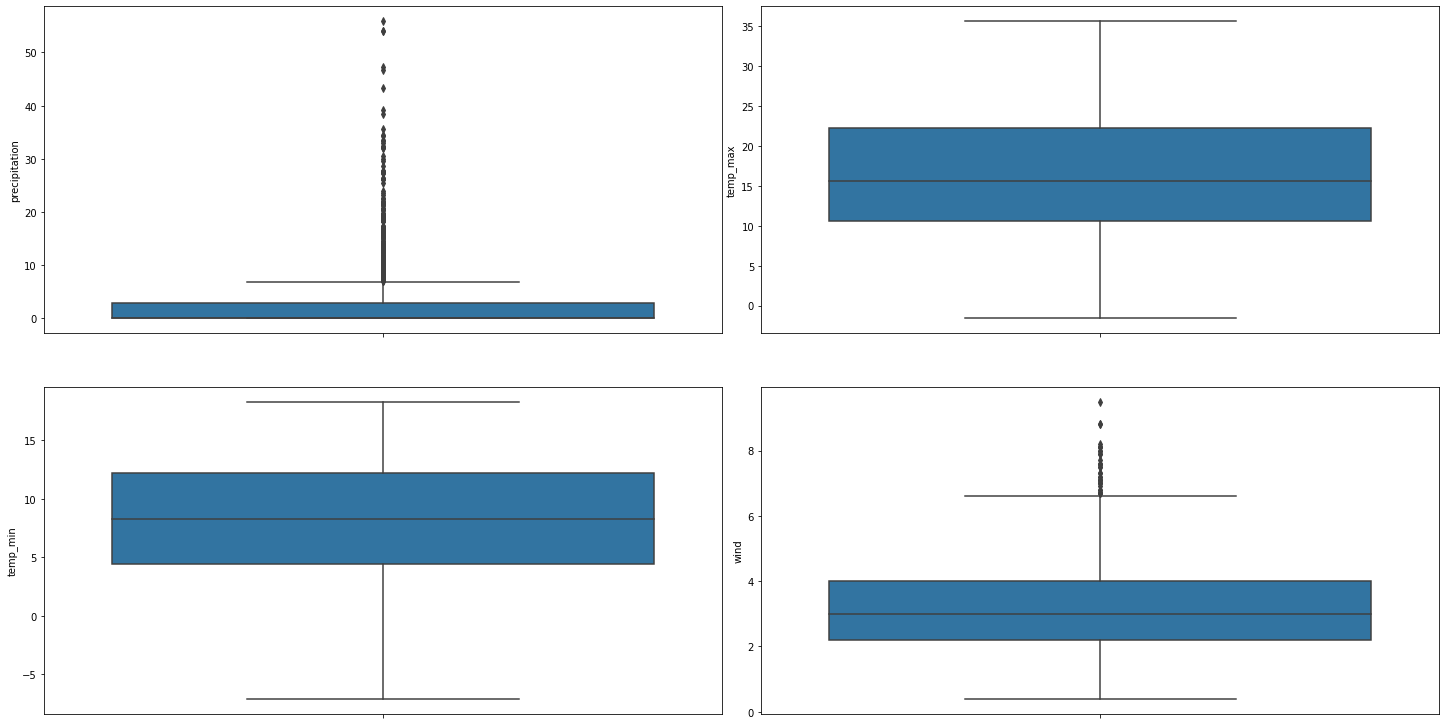

In [86]:
#Visualization of the Outliers for all columns using Boxplot
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,10))
weather_df2 = weather_df.drop("weather", axis=1)
index = 0
axs = axs.flatten()
for k, v in weather_df2.items(): 
    sns.boxplot(y=k, data=weather_df2, ax=axs[index]) 
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [87]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() #Label Encoding the Weather Column
weather_2 = le.fit_transform(weather_df['weather'])
weather_df2['weather_2'] = weather_2
# 0 - drizzle
# 1 - fog
# 2 - rain
# 3 - snow
# 4 - sun

In [88]:
weather_df2['weather_2'].value_counts()

2    641
4    640
1    101
0     53
3     26
Name: weather_2, dtype: int64

In [89]:
weather_df['weather'].value_counts()

rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: weather, dtype: int64

In [90]:
#Getting Outliers Percentage for all columns 
for k, v in weather_df2.items(): 
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1 #Inter-Quartile Range (IQR) Method
    v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(weather_df2)[0]
    print(f"{k} Outliers = {round(perc, 2)}")

precipitation Outliers = 14.1
temp_max Outliers = 0.0
temp_min Outliers = 0.0
wind Outliers = 2.33
weather_2 Outliers = 0.0


In [91]:
#Removing the Highest Percentage Outliers ("precipitation" column)
quantile1,quantile3= np.percentile(weather_df2["precipitation"],[25,75])
iqr=quantile3-quantile1
lower_bound=quantile1-(1.5*iqr)
upper_bound=quantile3+(1.5*iqr)
print(weather_df2.shape) #Dataset shape before removing the Outliers
var1=np.where(weather_df2['precipitation'] >=upper_bound)
var2=np.where(weather_df2['precipitation'] <=lower_bound)
weather_df2.drop(var1[0], inplace = True)
weather_df2.drop(var2[0], inplace = True)
print(weather_df2.shape) #Dataset shape after removing the Outliers

(1461, 5)
(1255, 5)


In [92]:
weather_df2.head()

,precipitation,temp_max,temp_min,wind,weather_2
0,0.0,12.8,5.0,4.7,0
2,0.8,11.7,7.2,2.3,2
4,1.3,8.9,2.8,6.1,2
5,2.5,4.4,2.2,2.2,2
6,0.0,7.2,2.8,2.3,2


In [93]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler

In [94]:
ct = make_column_transformer(
    (MinMaxScaler(),['precipitation', 'temp_max', 'temp_min', 'wind']), #Normalize the data
)

In [95]:
X = weather_df2.drop("weather_2", axis=1) #Features
Y = weather_df2["weather_2"] #Labels

In [96]:
#Splitting into Training and Testing Data
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=53) 

In [97]:
# Transform training data 
ct.fit(X_train)
#Transform training and test data with normalization 
#(MinMaxScaler)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

# **Random Forest Model**

In [125]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=25)

In [126]:
rfc.fit(X_train_normal, Y_train) #Fitting the Training Data into the Model 
predict = rfc.predict(X_test_normal) #Predicting the Test Data
accuracy = accuracy_score(Y_test, predict) #Finding out the Test accuracy
print(f"Accuracy of the model(Random Forest) is {round(accuracy*100, 2)} %")

Accuracy of the model(Random Forest) is 80.48 %


In [127]:
confusion_matrix(Y_test, predict)

array([[  1,   1,   0,   0,   9],
       [  0,   0,   1,   0,  19],
       [  0,   0,  79,   0,  10],
       [  0,   0,   1,   2,   0],
       [  0,   3,   5,   0, 120]])

In [128]:
#Using K-Fold Cross Validation for Prediction Using Random Forest
model_random = RandomForestClassifier(n_estimators = 25)
kfold= KFold(n_splits=5, random_state=72, shuffle=True) #K-Fold Cross Validation
scores = cross_val_score(model_random, X, Y, cv=kfold)
print('Cross validation accuracies :',scores*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores.mean()*100, 2)} % (Random Forest)") #Mean of all the accuracy scores

Cross validation accuracies : [78.48605578 81.2749004  81.2749004  82.47011952 79.6812749 ]
Overall Accuracy by using KFold method is 80.64 % (Random Forest)


# **Decision Tree Model**

In [129]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier() #Decision Tree Model
dtc.fit(X_train_normal, Y_train) #Fitting the Training Data into the Model

DecisionTreeClassifier()

In [130]:
dtc_predict = dtc.predict(X_test_normal) #Prediciting the Test Data
accuracy_dtc = accuracy_score(Y_test, dtc_predict) #Finding out the Test accuracy
print(f"Accuracy of the model(Decision Tree) is : {round(accuracy_dtc*100, 2)} %")

Accuracy of the model(Decision Tree) is : 74.5 %


In [131]:
confusion_matrix(Y_test, dtc_predict) #Confusion Matrix

array([[  2,   0,   0,   0,   9],
       [  0,   3,   2,   0,  15],
       [  1,   1,  78,   1,   8],
       [  0,   0,   1,   2,   0],
       [ 10,  11,   5,   0, 102]])

In [132]:
#Using K-Fold Cross Validation for Prediction Using Decision Tree
model_dtc = DecisionTreeClassifier()
kfold_dtc = KFold(n_splits=5, random_state=53, shuffle=True) #K-Fold Cross Validation
scores_dtc = cross_val_score(model_dtc, X, Y, cv=kfold_dtc)
print('Cross validation accuracies :',scores_dtc*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_dtc.mean()*100, 2)} % (Decision Tree)") #Mean of all the accuracy scores

Cross validation accuracies : [74.10358566 70.11952191 73.30677291 73.30677291 68.12749004]
Overall Accuracy by using KFold method is 71.79 % (Decision Tree)


# **Logistic Regression Model**

In [145]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression(max_iter=10000) #Logistic Regression Model
model_lr.fit(X_train_normal,Y_train) #Fitting the Training Data into the model

LogisticRegression(max_iter=10000)

In [148]:
lr_predict = model_lr.predict(X_test_normal) #Predicting the Test Data
accuracy_lr = accuracy_score(Y_test, lr_predict) #Finding out the Test accuracy
print(f"Accuracy of the model (Logistic Regression) is {round(accuracy_lr*100, 2)} %") 

Accuracy of the model (Logistic Regression) is 76.49 %


In [150]:
confusion_matrix(Y_test, lr_predict) #Confusion Matrix

array([[  0,   0,   0,   0,  11],
       [  0,   0,   0,   0,  20],
       [  0,   0,  64,   0,  25],
       [  0,   0,   3,   0,   0],
       [  0,   0,   0,   0, 128]])

In [151]:
#Using K-Fold Cross Validation for Prediction Using Logistic Regression
lr = LogisticRegression(max_iter=10000)
kfold_lr = KFold(n_splits=5, random_state=72, shuffle=True) #K-Fold Cross Validation
scores_lr = cross_val_score(lr, X, Y, cv=kfold_lr)
print('Cross validation accuracies :',scores_lr*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_lr.mean()*100, 2)} % (Logistic Regression)") #Mean of all the accuracy scores

Cross validation accuracies : [79.28286853 84.86055777 83.26693227 87.64940239 79.6812749 ]
Overall Accuracy by using KFold method is 82.95 % (Logistic Regression)


# **K-Nearest Neighbours (KNN) Model**

In [152]:
from math import sqrt
sqrt(len(Y_test)) #Finding out value of k

15.84297951775486

In [164]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean') #KNN Model
knn.fit(X_train_normal, Y_train) #Fitting the Training Data into the model

KNeighborsClassifier(metric='euclidean', n_neighbors=15)

In [166]:
knn_predict = knn.predict(X_test_normal) #Predicting the Test data
accuracy_knn = accuracy_score(Y_test, knn_predict) #Finding out the Test accuracy
print(f"Accuracy of the model(KNN) is : {round(accuracy_knn*100, 2)} %")

Accuracy of the model(KNN) is : 76.49 %


In [167]:
confusion_matrix(Y_test, knn_predict) #Confusion Matrix

array([[  2,   1,   0,   0,   8],
       [  0,   0,   1,   0,  19],
       [  0,   2,  66,   0,  21],
       [  0,   0,   3,   0,   0],
       [  1,   1,   2,   0, 124]])

In [168]:
#Using K-Fold Cross Validation for Prediction Using KNN
model_knn = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean')
kfold_knn = KFold(n_splits=5, random_state=103, shuffle=True) #K-Fold Cross Validation
scores_knn = cross_val_score(model_knn, X, Y, cv=kfold_knn)
print('Cross validation accuracies :',scores_knn*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_knn.mean()*100, 2)} % (KNN)") #Mean of all the accuracy scores

Cross validation accuracies : [71.71314741 69.72111554 66.93227092 72.90836653 77.29083665]
Overall Accuracy by using KFold method is 71.71 % (KNN)


# **Support Vector Machine (RBF) Model**

In [169]:
from sklearn.svm import SVC
svc = SVC(kernel = 'rbf') #SVM - RBF Model
svc.fit(X_train_normal, Y_train) #Fitting the Training Data into the Model 

SVC()

In [170]:
predict_rbf = svc.predict(X_test_normal) #Predicting the Test data
accuracy_svm_rbf = accuracy_score(Y_test, predict_rbf) #Finding out the Test accuracy
print(f"Accuracy of the model(SVM - RBF) is : {round(accuracy_svm_rbf*100, 2)} %")

Accuracy of the model(SVM - RBF) is : 76.89 %


In [171]:
confusion_matrix(Y_test, predict_rbf) #Confusion Matrix

array([[  0,   0,   0,   0,  11],
       [  0,   0,   0,   0,  20],
       [  0,   0,  65,   0,  24],
       [  0,   0,   3,   0,   0],
       [  0,   0,   0,   0, 128]])

In [173]:
#Using K-Fold Cross Validation for Prediction Using SVM - RBF
svm = SVC(kernel = 'rbf')
kfold_svm = KFold(n_splits=5, random_state=80, shuffle=True) #K-Fold Cross Validation
scores_svm = cross_val_score(svm, X, Y, cv=kfold_svm)
print('Cross validation accuracies :',scores_svm*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_svm.mean()*100, 2)} % (SVM - RBF)") #Mean of all the accuracy scores

Cross validation accuracies : [75.29880478 72.90836653 77.68924303 75.29880478 72.90836653]
Overall Accuracy by using KFold method is 74.82 % (SVM - RBF)
